# Predicting number of days until a Department of Buildings Complaint is inspected

#### Authors:
- __Jeremy Ondov:__ [GitHub](https://github.com/ondovj)
- __Mahdi Shadkam-Farrokhi:__ [GitHub](https://github.com/Shaddyjr) 
---

## Problem Statement
In New York City, building violations are frequently reported to the Department of Buildings (DOB), which is often initiated by a citizen. However, the length of time between the report and a response by the DOB may vary greatly depending on the location, violation type, and other factors. Citizens expectations for when a complaint will realistically be inspected would allow them to make more informed decisions, such as whether or not to inquire about their ticket or resend a duplicate complaint. The Department of Buildings would like-wise benefit from the reduction in redundant complaints. To this end, __we will create a predictive model that can estimate the number of days until a complaint is inspected.__

Given the continuous nature of the target, we will explore various __regression models and will use $R^2$ as our metric__ for model selection.

## Executive Summary

We gathered data from the Department of Buildings(DOB) on the Open NYC platform around September 2019. These data were mostly categorical and few in number, which proved challenging to work with. Our target variable was also something we would have to construct based on the time a complaint was filed into record and when it was actually inspected. Right away we saw some __odd behavior - most notably some observations had a negative number of days until inspection,__ meaning some complaints were filed after they were inspected. We later discovered this was due to some on-site inspections leading to staff-filed complaints, which were immediately inspected and filed later. We removed these unusual instances from the dataset.

Another issue we ran into was dealing with the sheer size of the dataset. We could not possibly load years of data into local memory, so we opted to sample at regular intervals from our dataset. This invariably leads to an assumption that the observations we sampled were representative of the entire dataset. For the most part, the rest of the cleaning process was fairly standard. 

After some preliminary modeling, we found our features to be lacking at predicting the target. So, we pulled additional data we felt may play a significant roll in predicting out target and merged the two. The outside data was census data, specifically focused on median income by zip code. Of course, this adds another dimension of complexity, since __we are almost certainly including implicit features associated with zip code, such as demographic and social economical confounders__ we may not want to include within our models. We also __conducted transfer learning by using K-Modes to engineer a new feature,__ representing each observation's most closely related cluster.

We then took basic preliminary steps to explore the data, such as looking for trends within the features that may have correlation to our target. We found a number of extreme outliers, suggesting some complaints have taken over 10 years to be inspected! Interestingly, __our target follows the gamma distribution,__ since it's related to "time until an event". We immediately considered using a GLM model. Unfortunately, due to a number of technical issues with the `statsmodels` package, we were unable to reach a satisfactory result. We then attempted a number of regression models, the best of which was a random forest, however it still performed poorly, considering the baseline. Lastly, we attempted to use time-series models, which also proved to be underfit.

__In the end, we were unable to find a satisfactory predictive model, though we may be able to glean some information from interpreting our best model, a random forest.__

## Table of Contents
1. [Data Dictionary](#Data-Dictionary)
1. [Loading libraries and data](#Loading-libraries-and-data)
1. [Data Cleaning](#Data-Cleaning)
    - [Removing Outliers](#Removing-Outliers)
1. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    - [Defining helper functions](#Defining-helper-functions)
    - [Exploring Days Until Inspection](#Exploring-Days-Until-Inspection)
    - [Exploring Special District](#Exploring-Special-District)
    - [Exploring Unit](#Exploring-Unit)
    - [Exploring Complaint Category](#Exploring-Complaint-Category)
    - [Exploring Zip Code](#Exploring-Zip-Code)
    - [Exploring Median Income](#Exploring-Median-Income)
    - [Feature Engineering - K-Modes Clustering](#Feature-Engineering---K-Modes-Clustering)
    - [Exploring clusters](#Exploring-clusters)
1. [Model Preperation](#Model-Preperation)
1. [Modeling](#Modeling)
    - [Baseline Model](#Baseline-Model)
    - [Random Forest](#Random-Forest)
    - [Gradient Boost](#Gradient-Boost)
1. [ARIMA](#ARIMA)
    - [Hyperparameter searching using `auto_arima`](#Hyperparameter-searching-using-auto_arima)
    - [Model Preparation for ARIMA](#Model-Preparation-for-ARIMA)
    - [Fitting and Scoring ARIMA](#Fitting-and-Scoring-ARIMA)
1. [SARIMAX](#SARIMAX)
    - [Model Preparation for SARIMAX](#Model-Preparation-for-SARIMAX)
    - [Modeling SARIMAX](#Modeling-SARIMAX)
1. [Model Selection](#Model-Selection)
    - [Regression Models](#Regression-Models)
    - [Time-Series Models](#Time-Series-Models)
1. [Model Evaluation](#Model-Evaluation)
    - [Feature Importances](#Feature-Importances)
    - [Random Forest Residuals](#Random-Forest-Residuals)
1. [Conclusion](#Conclusion)
1. [Recommendations](#Recommendations)
1. [Resources](#Resources)


## Data Dictionary
These data were cleaned from the original source using [the assocated cleaning notebook](./dob_data_cleaning.ipynb)

Column | Data Type | Description
- | - | :-
special_district|string|Indicates whether or not the building identified in the complaint is located in a Special District.
complaint_category|string|DOB Complaint Category Codes (01-Accident Construction/Plumbing, etc.)
unit|string|The most recent unit that was assigned to this complaint. It may have been initially assigned to one unit, and then referred to another unit for disposition.
zip_code|string|Zip code for the address of the building identified in the complaint.
med_inc_zip|integer|Median income imputed by zip code.
date_entered|date|Date complaint was filed
inspection_date|date|Date complaint was inspected
days_until_inspection|integer|Number of days between when complaint was filed and when it was officially inspected


## Loading libraries and data


In [181]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import pmdarima as pm
import statsmodels.formula.api as smf

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import r2_score
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from pmdarima import auto_arima

import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import math
import pickle

from sklearn.dummy import DummyRegressor
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.metrics import silhouette_score
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes

RANDOM_STATE = 12345

In [182]:
complaints = pd.read_csv('../datasets/cleaned.csv', index_col = 0, parse_dates = ["date_entered","inspection_date"])

In [183]:
complaints.head()

,special_district,complaint_category,unit,zip_code,med_inc_zip,date_entered,inspection_date,days_until_inspection
0,NOT SPECIAL,4B,SEP,10458,32129,2013-12-17,2013-12-24,7
1,NOT SPECIAL,73,MAN.,10075,129594,2009-09-21,2009-10-03,12
2,NOT SPECIAL,37,ERT,10011,123208,2015-09-02,2015-09-03,1
3,NOT SPECIAL,23,ERT,10462,49962,2010-08-25,2010-10-09,45
4,NOT SPECIAL,90,CITY,11220,42559,2009-07-20,2009-09-15,57


## Data Cleaning
Most of the major cleaning was done during the previous cleaning steps. Some ancillary data cleaning is still needed, however.

### Removing Outliers

The dataset has some significant outliers, which bear consideration; we've decided to remove these extreme observations from our training set.

In [184]:
complaints["days_until_inspection"].describe()

count    81739.000000
mean        87.204419
std        204.906661
min          1.000000
25%          5.000000
50%         24.000000
75%         84.000000
max       3402.000000
Name: days_until_inspection, dtype: float64

In [185]:
complaints["days_until_inspection"].max() / 365 # converting days to years

9.32054794520548

We can see some extreme DOB complaints took over 9 years to be inspected!

It's hard to tell if these are erroneous or valid, since there are many cases like this. Perhaps there's a pattern or some other commonality between these extreme observations.

---
#### An odd date

During model evaluation, we found the date associated with 2009-04-02 to have usual observations with large `days_until_inspection`

In [186]:
odd_dates = ["2009-04-02"]
complaints[complaints["date_entered"].isin(odd_dates)].sort_values("inspection_date", ascending = False).head()

,special_district,complaint_category,unit,zip_code,med_inc_zip,date_entered,inspection_date,days_until_inspection
60022,NOT SPECIAL,1G,EXCAV,11224,31630,2009-04-02,2018-06-29,3375
7046,NOT SPECIAL,1G,EXCAV,11211,66113,2009-04-02,2016-12-30,2829
50503,NOT SPECIAL,1G,EXCAV,10035,27932,2009-04-02,2014-08-25,1971
2149,NOT SPECIAL,1G,EXCAV,10035,27932,2009-04-02,2014-08-25,1971
88329,NOT SPECIAL,1G,EXCAV,10027,45536,2009-04-02,2014-07-28,1943


There may be some association with these exceptionally long inspection times and the `unit` "EXCAV".

---

To improve model performance, we'll remove all observations with more than 2800 days until inspection, or a little under 8 years.

In [187]:
# Setting outlier threshold
outlier_threshold = 2800
extreme_obs = complaints[complaints["days_until_inspection"] >= outlier_threshold].sort_values("days_until_inspection", ascending = False)
extreme_obs["unit"].value_counts()

QNS.     12
BRONX     6
EXCAV     6
ERT       4
BKLYN     3
SCFLD     3
MAN.      3
STALL     1
CITY      1
BEST      1
Name: unit, dtype: int64

There may be some association with these exceptionally long inspection times and the `unit` "QNS.".

In [188]:
extreme_obs.shape

(40, 8)

In [189]:
# percentage of all data
round(extreme_obs.shape[0] / complaints.shape[0], 4) * 100

0.05

We find 40 outlier observations, which account for about .05% of the data.`

In [190]:
# removing outliers
complaints.drop(index = extreme_obs.index, inplace = True)

## Exploratory Data Analysis

### Defining helper functions

In [191]:
def graph_time_aggregation(dataset, x, y, time_span, title):
    '''Plots a basic line plot based on a time_span aggregated by summation'''
    plt.title(title)
    dataset_by_time_span = dataset.resample(time_span).sum()
    sns.lineplot(y = dataset_by_time_span[y], x = dataset_by_time_span.index);
    plt.ylabel(capitalize_words(y))
    plt.xlabel(capitalize_words(x))

In [192]:
def capitalize_words(string):
    '''Returns string with each work capitalized'''
    
    return " ".join([word.capitalize() for word in string.replace("_"," ").split()])

In [205]:
def aggregation_plots(db, x, y):
    '''Plots a barplot and boxplot of the given features, limited to top 10 and sorted in descending order'''
    height_per_label = .3
    total_height = len(db[y].unique()[:10]) * height_per_label
    fig, axes = plt.subplots(ncols = 2, figsize = (10, total_height + (2 if total_height < 4 else 0)))
    ax1, ax2 = axes
    
    xlabel = capitalize_words(x.replace("_"," "))
    ylabel = capitalize_words(y.replace("_"," "))
    fig.suptitle("Average {} by {}".format(xlabel, ylabel), y = 1.075)
    
    sorted_label_values = db.groupby(y)[x].agg("mean").sort_values(ascending = False)[:10]

    sns.barplot(ax = ax1, x = db[x], y = db[y], order = sorted_label_values.index, orient = "h")
    ax1.set_ylabel(ylabel)
    ax1.set_xlabel(xlabel)
    
    sns.boxplot(ax = ax2, x = db[x], y = db[y], order = sorted_label_values.index, orient = "h")
    ax2.set_ylabel(ylabel)
    ax2.set_xlabel(xlabel)
    
    plt.tight_layout()

### Exploring Days Until Inspection

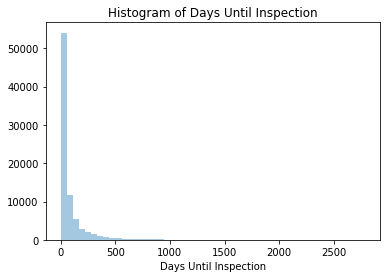

In [194]:
# Original `days_until_inspection`
plt.title("Histogram of Days Until Inspection")
sns.distplot(complaints["days_until_inspection"], kde = False, bins = 50, axlabel = "Days Until Inspection");

We find a heavily skewed distribution for our target variable, `days_until_inspection`, which is remniscent of an exponential or __gamma distribution.__ This makes even more sense, considering our target is a continuous non-negative value detailing a "time until an event occurs". 

#### Log transformation
Skewed distributions can sometimes be coerced to look more normal using the log transformation. If this is the case with our target, then we may be able to work with a linear regression or other simple model.

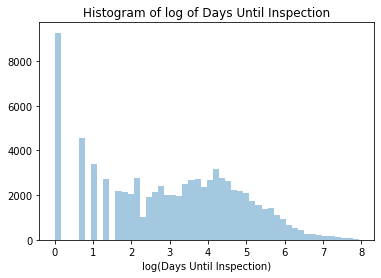

In [195]:
# Log transformed `days_until_inspection`
plt.title("Histogram of log of Days Until Inspection")
sns.distplot(np.log(complaints["days_until_inspection"]), axlabel="log(Days Until Inspection)", kde = False);

Log transforming our target variable does __not__ result in a normal-looking distribution, so we will keep the target feature as is.

#### Aggregating data by various time intervals

Given the temporal nature of our target, we suspect there are time-related dependencies.

In [196]:
# preparing data for visualization 
complaints_with_time_index = complaints.set_index("date_entered")[["days_until_inspection"]]

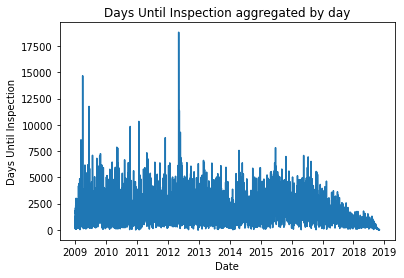

In [197]:
# by day
graph_time_aggregation(
    complaints_with_time_index, 
    "date", 
    "days_until_inspection", 
    "D", 
    "Days Until Inspection aggregated by day"
)

We find after 2016, there appears to be a downward trend in the number of days until a complaint is inspected.

We must consider the recency of the tail end, however, since these complaints are less likely to be "CLOSED" and therefore not seen in the data.

It's difficult to tell if there's any seasonality in these data when aggregating by day.

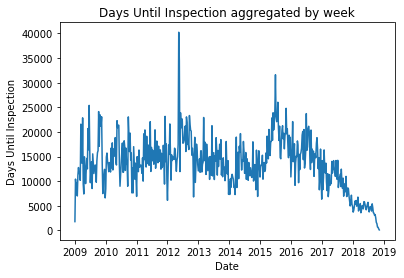

In [198]:
# by week
graph_time_aggregation(
    complaints_with_time_index, 
    "date", 
    "days_until_inspection", 
    "W", 
    "Days Until Inspection aggregated by week"
)

It's difficult to tell if there's any seasonality in these data when aggregating by week.

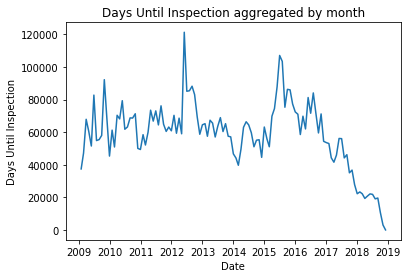

In [199]:
# by month
graph_time_aggregation(
    complaints_with_time_index, 
    "date", 
    "days_until_inspection", 
    "M", 
    "Days Until Inspection aggregated by month"
)

There may be some seasonality by month, though it appears somewhat irregular.

---
__We may want to consider testing for seasonality and using an ARIMA or SARIMAX model.__

#### Testing for seasonality
For simplicity, we'll test for seasonality using with average days until inspection _by month._

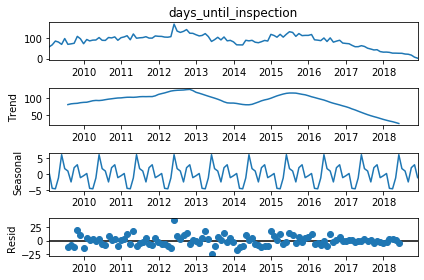

In [200]:
# aggregating mean days_until_inspection by month
avg_days_until_inspection_by_month = complaints_with_time_index.resample("M").mean()
seasonal_decompose(avg_days_until_inspection_by_month["days_until_inspection"]).plot()
plt.show()

After decomposing the data __we find a seasonal component, which suggests a SARIMAX model may be worth exploring.__

### Exploring Special District

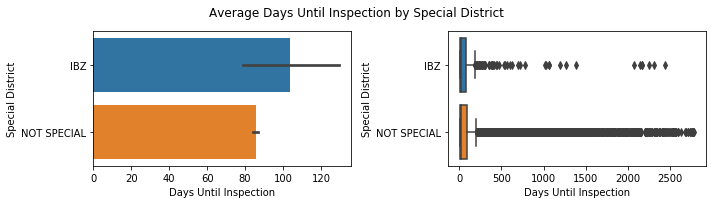

In [201]:
# Special District
aggregation_plots(complaints, "days_until_inspection", "special_district")

__We do not see a significant difference in average `days_until_inspection` between Special Districts,__ however we do see a wide range in individual observations for "NOT SPECIAL" districts.

### Exploring Unit

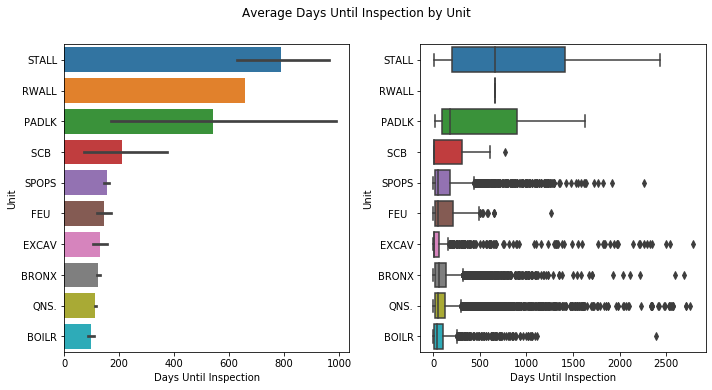

In [202]:
# Unit
aggregation_plots(complaints, "days_until_inspection", "unit")

__The STALL and PADLK units appear to have the longest average days until inspection__ with little different between the other units. Other Units, however, have much more extreme outliers.

### Exploring Complaint Category

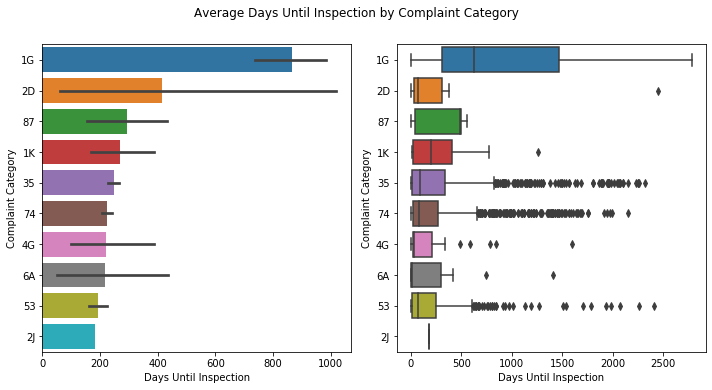

In [203]:
# Complaint Category
aggregation_plots(complaints, "days_until_inspection", "complaint_category")

__The "1G" complaint category appears to take significantly longer to inspect than all other categories,__ even when taking into account the extreme ranges seen in those categories. 

We may want to consider splitting our dataset to handle "1G" and non-"1G" complaint categories.

### Exploring Zip Code

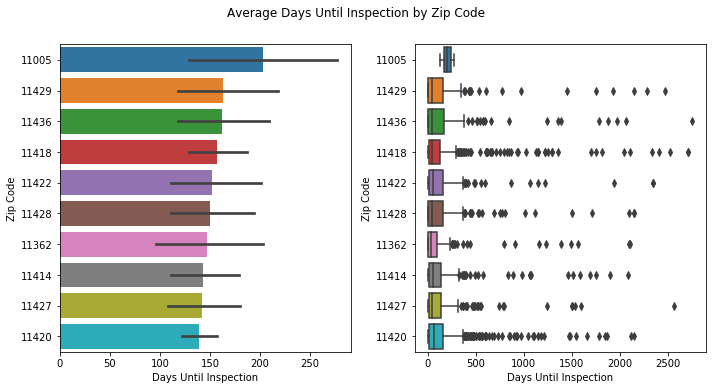

In [206]:
# Zip Code
aggregation_plots(complaints, "days_until_inspection", "zip_code")

Zip Code does not appear to be a significant feature.

In addition, we encountered a number of issues with these data zip codes:
- Many zip codes were missing and while we were able to infer the zip codes, based in the `house_street` and `house_number` and using the Google Maps API, this proved to be impractical.
- A few zip codes also appeared to be outdated. Over time the city of New York has decommissioned some zip codes and created new ones (for example, 11249). Such zip codes were in the dataset, and would require further assumptions to be made.

For these reasons __we'll be removing the Zip Code feature from model consideration.__

### Exploring Median Income

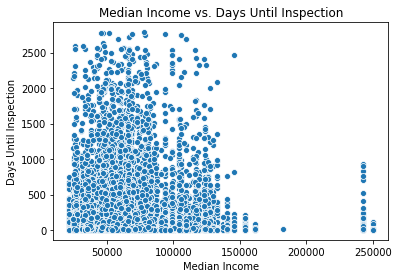

In [25]:
# Median Income
plt.title("Median Income vs. Days Until Inspection")
sns.scatterplot(data = complaints, x = "med_inc_zip", y = "days_until_inspection");
plt.xlabel("Median Income")
plt.ylabel("Days Until Inspection");

Besides a few extreme income values, __there does not appear to be a clear correlation between median income and the number of days until a complaint is inspected.__

### Feature Engineering - K-Modes Clustering

In order to find further connections between the complaint entries that may help the modeling phase, we are going to apply clustering as a form of EDA and feature engineering. As most of the data here is categorical, we are going to use the KModes modeling technique, which is an adaptation of KMeans clustering. As categorical data cannot truly have distances between values, KMeans is not an accurate tool for this scenario. Instead of numerical distances, KModes utilizes each row's combined values of each category (column, or feature), and determines for each cluster what the mode of that category  is. For each row, the number of columns where these values differs becomes the "distance". In this way, the algorithm can still determine the similarity and difference between the entries and the cluster "centroids".

For this process, we are only interested in the categorical columns that are going to have an impact on the modeling phase. Complaint status, address, and others are not needed for this analysis so they can be dropped. The included zip code median income will also be dropped as it is a continuous numerical feature and will not be available for the KModes algorithm.

#### Preprocessing

We'll select the key features we plan to put into the model and use K-prototypes to create a column of possible clusters as a way of improving model performance.

In [26]:
# selected features
kmode_features = ["special_district", "complaint_category", "unit"]

kmode_df = complaints[kmode_features]
kmode_df.head()

,special_district,complaint_category,unit
0,NOT SPECIAL,4B,SEP
1,NOT SPECIAL,73,MAN.
2,NOT SPECIAL,37,ERT
3,NOT SPECIAL,23,ERT
4,NOT SPECIAL,90,CITY


One of the difficult parts of clustering analysis is to determine the optimal number of clusters to choose (when using algorithms that cannot determine this on their own). To aid in this determination, we will loop through a range of cluster numbers, and analyze each model's cost, defined in the library documentation as the sum distance of all points to their respective cluster centroids, to determine the optimal number of clusters.

We will create a dictionary to store each of the model instances, with the number of clusters being used at the key for each model. We will also separately store the costs for each model to easily access these values. The targeted range of cluster numbers will be all numbers from 3 to 20.

#### Searching for best `n_clusters`

In [27]:
# setting dictionary and lists to store models/results
km_objs = []
# looping through cluster range
for i in range(3, 10, 1):
    print("running KModes with ", i, "clusters")
    km = KModes(n_clusters = i, n_init = 10, random_state = RANDOM_STATE, n_jobs = -1, verbose = 2)
    km_objs.append(km.fit(kmode_df))

running KModes with  3 clusters
Initialization method and algorithm are deterministic. Setting n_init to 1.
running KModes with  4 clusters
Initialization method and algorithm are deterministic. Setting n_init to 1.
running KModes with  5 clusters
Initialization method and algorithm are deterministic. Setting n_init to 1.
running KModes with  6 clusters
Initialization method and algorithm are deterministic. Setting n_init to 1.
running KModes with  7 clusters
Initialization method and algorithm are deterministic. Setting n_init to 1.
running KModes with  8 clusters
Initialization method and algorithm are deterministic. Setting n_init to 1.
running KModes with  9 clusters
Initialization method and algorithm are deterministic. Setting n_init to 1.


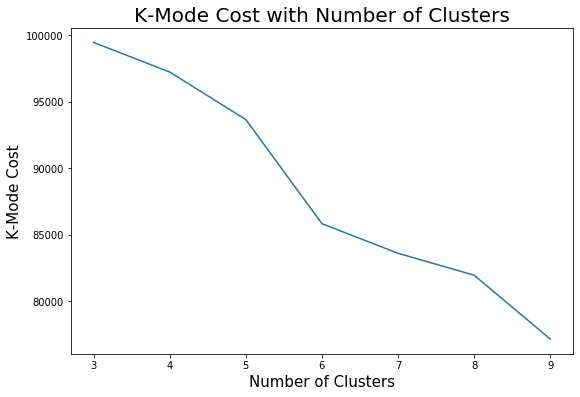

In [28]:
plt.figure(figsize=(9, 6))
plt.plot(range(3, len(km_objs) + 3), [km_obj.cost_ for km_obj in km_objs])
plt.title("K-Mode Cost with Number of Clusters", size=20)
plt.xticks(range(3, len(km_objs) + 3))
plt.xlabel("Number of Clusters", size=15)
plt.ylabel("K-Mode Cost", size=15);

When trying to identify the optimal number of clusters for use for modeling, it can be useful to identify an inflection point in the way that the efficiency metric changes with the number of clusters, such as the "costs" displayed here. However, this curve does not have a single clear point to choose from. We will take a deeper look at the difference between these costs.

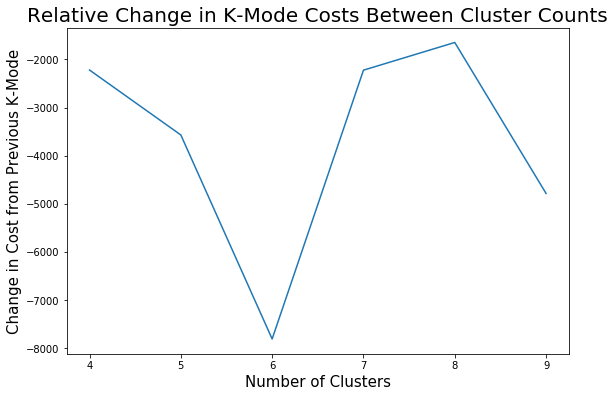

In [29]:
plt.figure(figsize=(9, 6))
plt.plot(range(4, len(km_objs) + 3), [obj.cost_ - km_objs[i].cost_ for i, obj in enumerate(km_objs[1:])])
plt.title("Relative Change in K-Mode Costs Between Cluster Counts", size=20)
plt.xticks(range(4, len(km_objs) + 3))
plt.xlabel("Number of Clusters", size=15)
plt.ylabel("Change in Cost from Previous K-Mode", size=15);

Looking at this derivative of the change in cost per cluster, 6 clusters emerges as the best number to use, as it reduces the cost the most, without adding too many extraneous clusters.

#### Exploring best `n_clusters`

In [30]:
# exploring n_clusters = 6
km_objs[3].cluster_centroids_

array([['NOT SPECIAL', '45', 'QNS.'],
       ['NOT SPECIAL', '05', 'BKLYN'],
       ['NOT SPECIAL', '63', 'ERT  '],
       ['NOT SPECIAL', '83', 'ELEVR'],
       ['NOT SPECIAL', '73', 'MAN.'],
       ['NOT SPECIAL', '4B', 'SEP  ']], dtype='<U11')

In [31]:
pd.Series(km_objs[3].labels_).value_counts(normalize = True)

0    0.520863
1    0.186918
2    0.179292
5    0.047797
4    0.037981
3    0.027148
dtype: float64

I appears over half of the observations belong to the first cluster, which tend to belong to the complaint category "45" and are handled by the "QNS." unit.

#### Adding cluster column

In [32]:
# adding clusters to dataset
complaints["cluster"] = (km_objs[3].labels_ + 1).astype(str) # must be categorical

### Exploring clusters

#### Average Median Income by Cluster

In [33]:
med_by_cluster = complaints.groupby("cluster")["med_inc_zip"].mean().sort_values()
med_by_cluster

cluster
3    60486.188900
1    63541.510880
2    64142.703490
4    65544.562218
6    66493.746735
5    85021.932001
Name: med_inc_zip, dtype: float64

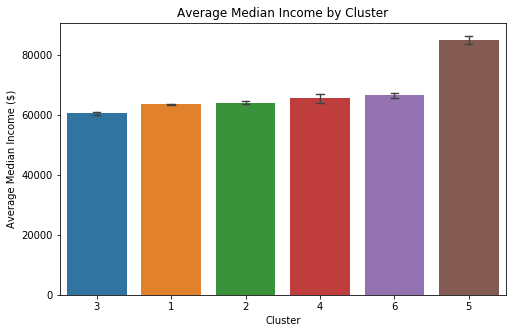

In [34]:
plt.figure(figsize=(8,5))
plt.title("Average Median Income by Cluster")
sns.barplot(data = complaints, x = "cluster", y = "med_inc_zip", capsize = .1, errwidth = 1.4, order = med_by_cluster.index)
plt.ylabel("Average Median Income ($)")
plt.xlabel("Cluster");

Many clusters do not seem to show a large distinction between each other, however, the 5th cluster appears to have a significantly higher average median income. This may show a connection between the other features and median income.

#### Days until inspection by cluster

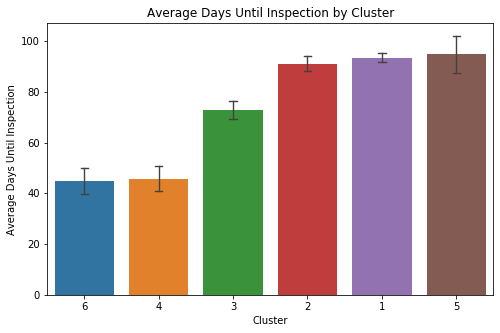

In [35]:
days_by_cluster = complaints.groupby("cluster")["days_until_inspection"].mean().sort_values()

plt.figure(figsize=(8,5))
plt.title("Average Days Until Inspection by Cluster")
sns.barplot(data = complaints, x = "cluster", y = "days_until_inspection", capsize = .1, errwidth = 1.4, order = days_by_cluster.index)
plt.ylabel("Average Days Until Inspection")
plt.xlabel("Cluster");

Again, we some some clusters have a very similar average days until being inspected, but do some roughly 3 unique groups of clusters that may serve as a useful feature for modeling.

## Model Preperation

In [83]:
target = "days_until_inspection"
reg_features = ["special_district", "complaint_category", "unit", "med_inc_zip", "cluster"]

# establish features
reg_X = pd.get_dummies(complaints[reg_features], drop_first = True)
# establish target
reg_y = complaints[target]

# train/test split
reg_X_train, reg_X_test, reg_y_train, reg_y_test = train_test_split(reg_X, reg_y, random_state = RANDOM_STATE)

## Modeling

First, we'll explore some traditional models, such as Random Forest and Gradient Boost.

Then, we'll see if an ARIMA or SARIMAX model perform better with our time-sensative target variable.

### Baseline Model

In [84]:
dummy = DummyRegressor("mean")

dummy.fit(reg_X_train, reg_y_train)

DummyRegressor(constant=None, quantile=None, strategy='mean')

In [85]:
# train score
dummy.score(reg_X_train, reg_y_train)

0.0

In [86]:
# test score
dummy.score(reg_X_test, reg_y_test)

-6.908867839650057e-05

In [40]:
# train score
cross_val_score(dummy, reg_X, reg_y).mean()

-2.6506864257846984e-05

As expected, the baseline model performs close to 0 $R^2$. Any model that can perform better will be better than blindly guessing the average number of days until a complaint is inspected.

### Random Forest

In [41]:
rf = RandomForestRegressor()

rf_params = {
    "n_estimators": [50],
    "max_depth": [None],
    "max_features": [50]
}

rf_gs = GridSearchCV(rf, rf_params, cv = 5, n_jobs = -1)

rf_gs.fit(reg_X_train, reg_y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [42]:
rf_gs.best_params_

{'max_depth': None, 'max_features': 50, 'n_estimators': 50}

In [43]:
# train score
rf_gs.score(reg_X_train, reg_y_train)

0.35646881702746513

In [44]:
# test score
rf_gs.score(reg_X_test, reg_y_test)

0.07324363092683361

In [45]:
# train score
cross_val_score(rf_gs.best_estimator_, reg_X, reg_y).mean()

0.06677036903355234

Given how underfit our model is with a training $R^2$ of 35% and a testing $R^2$ of 8%, a natural next step would be to try a boosting model.

### Gradient Boost

In [46]:
gb = GradientBoostingRegressor()

gb_params = {
    "n_estimators": [50],
    "max_depth": [None],
    "max_features": [50]
}

gb_gs = GridSearchCV(gb, gb_params, cv = 5, n_jobs = -1)

gb_gs.fit(reg_X_train, reg_y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_no_change=None,
                 

In [47]:
gb_gs.best_params_

{'max_depth': None, 'max_features': 50, 'n_estimators': 50}

In [48]:
# train score
gb_gs.score(reg_X_train, reg_y_train)

0.3818546286259279

In [49]:
# test score
gb_gs.score(reg_X_test, reg_y_test)

-0.003961805501477178

In [50]:
# train score
cross_val_score(gb_gs.best_estimator_, reg_X, reg_y).mean()

0.007738085548746954

Yet again, our model is underfit. With a training $R^2$ of 38% and a testing $R^2$ close to 0%, the Gradient Boost model does no better than our baseline model.

---
Given the temporal nature of our target and the clear lack of correlation between our features and our target, we'll explor an ARIMA model using only the target.

## ARIMA
We've already seen some seasonality components in our data, which is a motivating reason for exploring a ARIMA model.

We'll be using an weekly aggregation of average `days_until_inspection`.

In [51]:
# ARIMA SETUP
arima_df = complaints.set_index("date_entered")[["days_until_inspection"]].resample("W").mean().dropna().sort_index()

#### Determining `d` using ADF (Augmented Dickey Fuller) Test

We can use the Augmented Dickey Fuller hypothesis test to check for stationarity - a requirement for ARIMA.

In [52]:
# no differencing
result = adfuller(arima_df[target])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.312231
p-value: 0.923754
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


In [53]:
# diff of 1
arima_df_diff_1 = arima_df[target].diff(1).dropna()
result = adfuller(arima_df_diff_1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -11.455810
p-value: 0.000000
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


By __differencing once,__ with a 95% confidence, we reject the null hypothesis accept our data has stationarity (`d = 1`).

#### Determining `p` using autocorrelation function

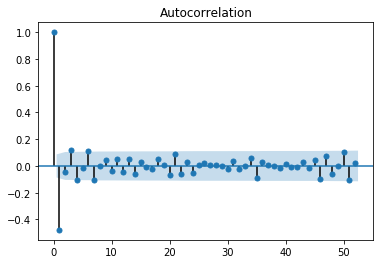

In [54]:
plot_acf(arima_df_diff_1, lags=52)
plt.show()

Using the once differenced data, we find a strong negative correlation between months within 1 lag and no other significant lags. This suggests we have to consider a moving average and assume no auto-regression (`p = 0`).

#### Determining `q` using partial-autocorrelation function

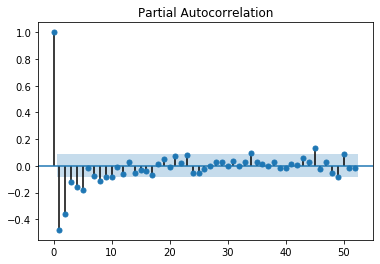

In [55]:
plot_pacf(arima_df_diff_1, lags=52)
plt.show()

We see an immediate significant lag that trails off to insignificance. We will use the first lag from the autocorrelation to determine the moving average term (`q = 1`).

We can also note here the somewhat cyclical nature of the labs, further suggesting a seasonal component to the data.

### Hyperparameter searching using `auto_arima`

To verify our findings for the order as $(p,q,d) = (0,1,1)$, we can use `auto_arima` to gridsearch the best order for our ARIMA model.

In [56]:
fitted_arima = auto_arima(
    arima_df,
    d = 1,
    start_p = 0, start_q = 0,
    seasonal = False
)

In [57]:
fitted_arima.order

(0, 1, 1)

We're confident an order of (0,1,1) is best to use in our model.

### Model Preparation for ARIMA

In [58]:
order = (0, 1, 1)

y_train, y_test = train_test_split(arima_df, test_size = .1, shuffle = False)

#### Time Series Baseline Model

In [59]:
dummy_arima = DummyRegressor("mean")

dummy_arima.fit(y_train, y_train)

DummyRegressor(constant=None, quantile=None, strategy='mean')

In [60]:
# train score
dummy_arima.score(y_train, y_train)

0.0

In [61]:
# test score
dummy_arima.score(y_test, y_test)

-75.2125088129619

Unsurprisingly, the dummy model reveals what we already know; the more recent observations have fewers complaints with a status of "CLOSED", making them less similar to previous observations.  

### Fitting and Scoring ARIMA

In [62]:
arima = ARIMA(y_train, 
              order = order,
             freq = "W")

fitted_arima = arima.fit()

In [63]:
fitted_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                ARIMA Model Results                                
===================================================================================
Dep. Variable:     D.days_until_inspection   No. Observations:                  461
Model:                      ARIMA(0, 1, 1)   Log Likelihood               -2009.992
Method:                            css-mle   S.D. of innovations             18.915
Date:                     Sun, 03 May 2020   AIC                           4025.985
Time:                             21:43:37   BIC                           4038.385
Sample:                         01-11-2009   HQIC                          4030.867
                              - 11-05-2017                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -0.0401      0.169     -0.238      0.812      -0.371       0.291
ma.L1.D.days_until_inspection    -0.8102      0.030    -26.920      0.000      -0.869      -0.751
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.2342           +0.0000j            1.2342            0.0000
-----------------------------------------------------------------------------
"""

In [64]:
# train score
r2_score(y_train[1:], fitted_arima.fittedvalues)

-12.913687619780772

In [65]:
# test score
arima_preds, _, arima_conf_int = fitted_arima.forecast(steps = len(y_test))

r2_score(y_test, arima_preds)

-4.406486997926177

Clearly our model does not perform well on the data as it performs technically better than the baseline model, but still terribly overall.

We did omit exogenous features as well as a seasonal component, which naturally leads us to attempt a SARIMAX model.

## SARIMAX


#### Determining `S`, seasonal component

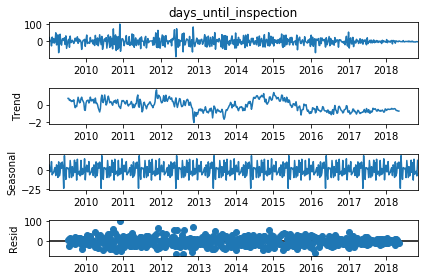

In [66]:
seasonal_decompose(arima_df_diff_1).plot()
plt.show()

We find a strong weekly seasonal component (`S = 52`).

### Model Preparation for SARIMAX

After multiple issues with an excessive number of dummy features, we've decided to reduce our exogenous features to the median income and the ordinal engineered feature "cluster"   

In [67]:
target = "days_until_inspection"
features = ["med_inc_zip", "cluster"]

complaints_by_date = complaints.set_index("date_entered")

# establish features
X = pd.get_dummies(complaints_by_date[features], drop_first = True)
# establish target
y = complaints_by_date[target]

## resampling by week and aggregating by mean
X = X.resample("W").mean()
y = y.resample("W").mean()

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .1, shuffle = False)

order = (0, 1, 1) # previously determined
seasonal_order = (0, 1, 1, 7)

### Modeling SARIMAX

In [68]:
sarimax = SARIMAX(endog = y_train,
                 order = order,
                 seasonal_order = seasonal_order,
                 exog = X_train,
                 enforce_stationarity=False, 
                 enforce_invertibility=False,
                 freq='W'
                )

fitted_sarimax = sarimax.fit()

In [69]:
fitted_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:             days_until_inspection   No. Observations:                  462
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 7)   Log Likelihood               -1950.264
Date:                           Sun, 03 May 2020   AIC                           3918.527
Time:                                   21:43:39   BIC                           3955.410
Sample:                               01-04-2009   HQIC                          3933.071
                                    - 11-05-2017                                         
Covariance Type:                             opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
med_inc_zip    -0.0001      0.000     -0.395      0.693      -0.001       0.001
cluster_2      11.2525     23.710      0.475      0.635     -35.217      57.722
cluster_3     -63.6369     21.738     -2.927      0.003    -106.242     -21.032
cluster_4     -51.2849     88.936     -0.577      0.564    -225.597     123.027
cluster_5      -8.5955     43.628     -0.197      0.844     -94.104      76.913
cluster_6     -87.3262     26.776     -3.261      0.001    -139.807     -34.846
ma.L1          -0.7962      0.024    -33.135      0.000      -0.843      -0.749
ma.S.L7        -1.0000      0.064    -15.720      0.000      -1.125      -0.875
sigma2        355.0791      0.015   2.45e+04      0.000     355.051     355.108
===================================================================================
Ljung-Box (Q):                       32.28   Jarque-Bera (JB):                24.11
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               0.51   Skew:                             0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number  3e+23. Standard errors may be unstable.
"""

At 95% confidence, we find most of the features have some significant role, with many of the clusters being insignificant factors.

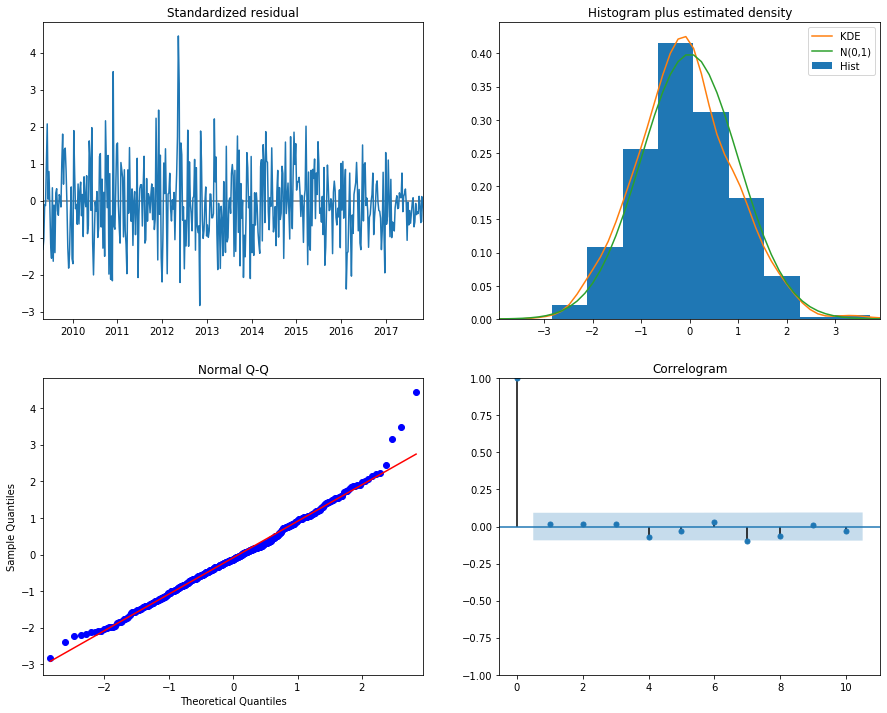

In [70]:
fitted_sarimax.plot_diagnostics(figsize=(15, 12));

Looking at the training data, our model diagnostics suggests that the model residuals are normally distributed.

- We see that the KDE follow the standard normal distribution with mean 0 and standard deviation of 1.
- The qq-plot shows that the ordered distribution of residuals follows the linear trend of the samples.
- The residuals don’t display any signs of seasonality and appear to be relatively stationary. This is confirmed by the autocorrelation (bottom right), which shows the residuals have a low correlation with lagged versions of itself.

These observations lead us to conclude that __our model performs reasonably well on the training data.__

In [71]:
# train score
r2_score(y_train, fitted_sarimax.fittedvalues)

0.45009583411719833

In [72]:
# test score
sarimax_preds= fitted_sarimax.forecast(steps = len(y_test), exog= X_test)

r2_score(y_test, sarimax_preds)

-3.9934685561723695


Our SARIMAX model may appear to perform better than the baseline, however __it still performs close to 0% $R^2$ on unseen data making it a poor model.__

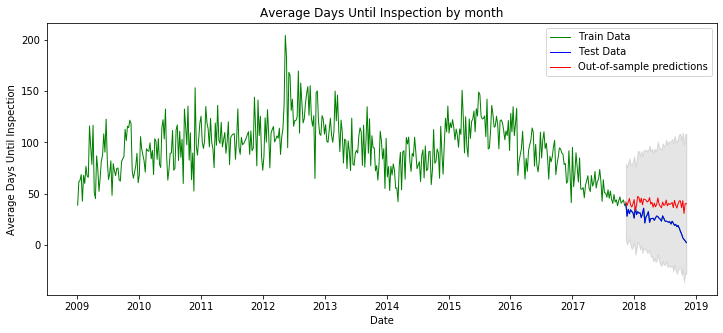

In [73]:
sarimax_preds = fitted_sarimax.get_forecast(steps = len(y_test), exog = X_test)

pred_ci = sarimax_preds.conf_int()

upper_conf_int = pred_ci.iloc[:,0]
lower_conf_int = pred_ci.iloc[:,1]

plt.figure(figsize=(12,5))
plt.title("Average Days Until Inspection by month")
plt.plot(y.index, y, lw=1, color='green', ls='solid',label='Train Data')
plt.plot(y_test.index, y_test, lw=1, color='blue', ls='solid',label='Test Data')
plt.plot(y_test.index, sarimax_preds.predicted_mean, lw=1, color='red', ls="solid",  label='Out-of-sample predictions')
plt.xlabel("Date")
plt.ylabel("Average Days Until Inspection")

# conf int
plt.fill_between(y_test.index, lower_conf_int, upper_conf_int, color='k', alpha=0.1);
plt.legend();

From the training set (in green), we can see why our model is confounded - the majority of the training data shows a relatively even trend. However, __after 2016 there is a clear downward trend, which our model is not able to predict for very well__ (in red). The blue line represents the true testing dataset.

#### Creating `vizResids` function

`vizResids` is a convenience function to abstract the relevant regression-like model evaluation graphs:
1. True Values ($y$) vs. Predictions ($\hat{y}$)
2. Residuals Plot
3. Residuals Histogram

In [74]:
def vizResids(model_title, target_name, y_true, y_preds):
    resids = y_true - y_preds
    score = r2_score(y_true, y_preds)
    # HANDLING SUBPLOTS
    fig, axes = plt.subplots(2, 2, figsize=(10,8)) # 2 row x 2 columns
    fig.suptitle(f"{model_title}: $R^2$ = {score:2.2%}", fontsize = 24, y = 1.05)

    ax_1 = axes[0][0]
    ax_2 = axes[0][1]
    ax_3 = axes[1][0]

    fig.delaxes(axes[1][1])
    subplot_title_size = 18
    subplot_label_size = 14
    
    # 1ST PLOT - y_true vs. y_pred
    ax_1.set_title("True Values ($y$) vs. Predictions ($\hat{y}$)", fontsize = subplot_title_size, pad = 10)
    maxDist = max(max(y_preds),max(y_true)) # maxiumum value used to determin x_lim and y_lim
    minDist = min(min(y_preds),min(y_true)) # maxiumum value used to determin x_lim and y_lim
    # 45deg line, signifying prediction == true value
    ax_1.plot((minDist,maxDist),(minDist,maxDist), c = "r", alpha = .7);
    
    sns.scatterplot(ax = ax_1, x = y_true, y = y_preds, alpha = .5)
    ax_1.set_xlabel("True Values ($y$)", fontsize = subplot_label_size, labelpad = 10)
    ax_1.set_ylabel("Predictions ($\hat{y}$)", fontsize = subplot_label_size, labelpad = 10)

    # 2ND PLOT - residuals
    ax_2.set_title("Residuals", fontsize = subplot_title_size)
    sns.scatterplot(ax = ax_2, x = y_preds, y = resids, alpha = .5)
    ax_2.set_ylabel(target_name, fontsize = subplot_label_size)
    ax_2.axhline(0, c = "r", alpha = .7);

    # 3RD PLOT - residuals histogram
    ax_3.set_title("Histogram of residuals", fontsize = subplot_title_size)
    sns.distplot(resids, ax = ax_3, kde = False);
    ax_3.set_xlabel(target_name, fontsize = subplot_label_size)
    ax_3.set_ylabel("Frequency", fontsize = subplot_label_size)

    plt.tight_layout() # handles most overlaping and spacing issues

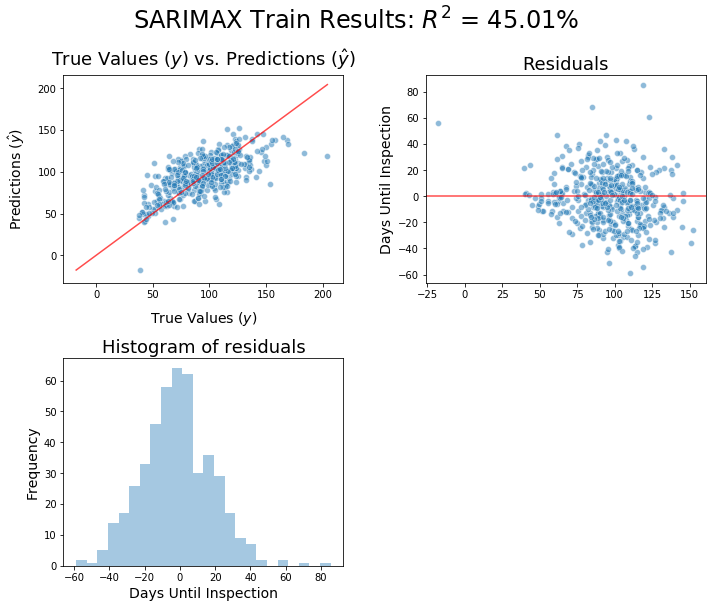

In [75]:
vizResids("SARIMAX Train Results", "Days Until Inspection", y_train, fitted_sarimax.predict(start=0,end=-1, exog = X_train))

As we saw before, our model's training resituals are normally distributed (bottom left). While our predictions cluster around the optimal prediction (upper left in red) there is __clearly a lack of consistency leading to large variance in the residuals with a lack of homoscedasticity.__

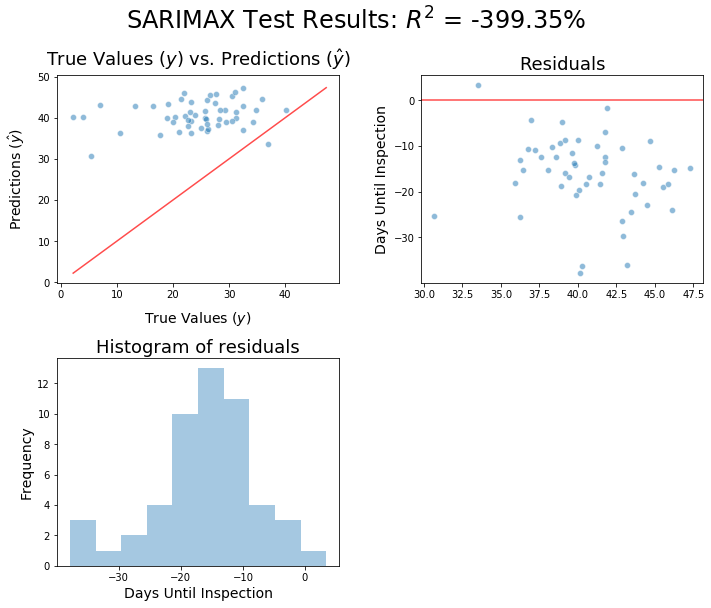

In [76]:
vizResids("SARIMAX Test Results", "Days Until Inspection", y_test, sarimax_preds.predicted_mean)

Our test predictions clearly shows the __inability of our model to predict the downward trend in the data.__ Our model tends to predict higher than the true values in the test set (upper left). We also see a clear shift in the residuals, which remain normally distributed, but with a mean closer to -15 (bottom left). The residuals plot (upper right) also verifies this finding - we see a __huge downward shift in the residuals being mostly negative with a wide variance.__

## Model Selection

### Regression Models

Model | Train Score | Test Score
-|-|-
DummyRegressor | 0% | 0%
Random Forest |35%| 7.69%
Gradient Boost |38%| 1%

### Time-Series Models
Model | Train Score | Test Score
-|-|-
DummyARIMA| 0%| 0%
ARIMA |0%| 0%
SARIMAX |45%| 0%

_NOTE: negative $R^2$ scores have been set to 0, since the score cannot technically fall below this value._

Interestingly, our "best" model was the Random Forest at 35% $R^2$ on the training data and 7.69% on the test data. This is still clearly an underfit model, however, we may be able to glean something from the model.

## Model Evaluation

Given the lack of interpretability of the Random Forest algorithm, we can look at feature importances along with standard regression residuals.

### Feature Importances

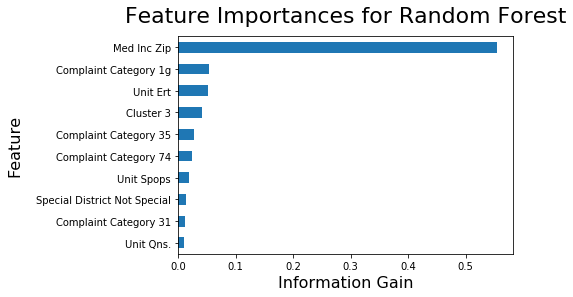

In [92]:
feature_importances = pd.Series(rf_gs.best_estimator_.feature_importances_, index = reg_X.columns.str.replace("_"," ").map(capitalize_words))

plt.title("Feature Importances for Random Forest", size = 22, pad = 14)
feature_importances.sort_values(ascending = False)[:10].sort_values().plot(kind = "barh")
plt.xlabel("Information Gain", size = 16)
plt.ylabel("Feature", size = 16, labelpad = 14);

We find the most important feature for our best performing model happens to be Median Income, which was imputed based on Zip Code. This brings into question some ethical concerns about how these data relate to socio-economic and demographic features, which we may want to consider removing. 

### Random Forest Residuals

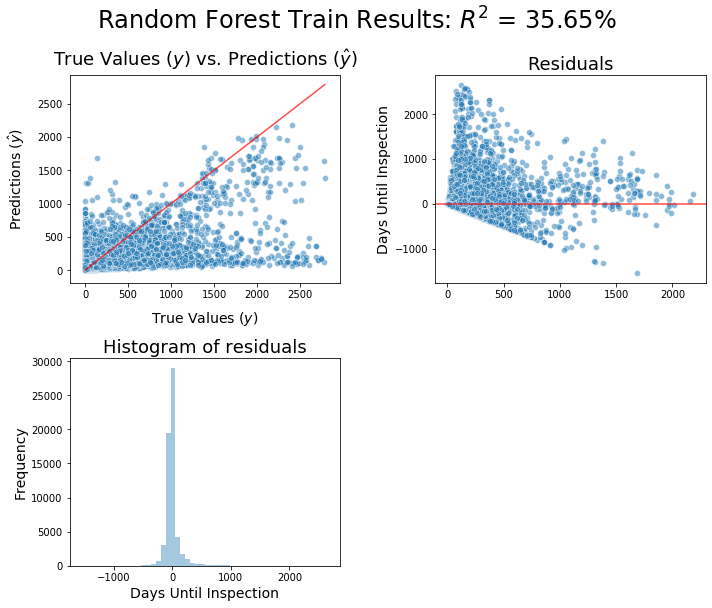

In [95]:
vizResids("Random Forest Train Results","Days Until Inspection", reg_y_train, rf_gs.predict(reg_X_train))

In spite our model being underfit, we see somewhat normally distributed residuals (bottom left). However, the model predictions are all over the place - with __inaccurate predictions both wildly over and underpredicting__ (upper left). The most striking visual is the residual plot (upper right), which shows just how poorly this model performs given the heteroscedastic shape even on the training set.

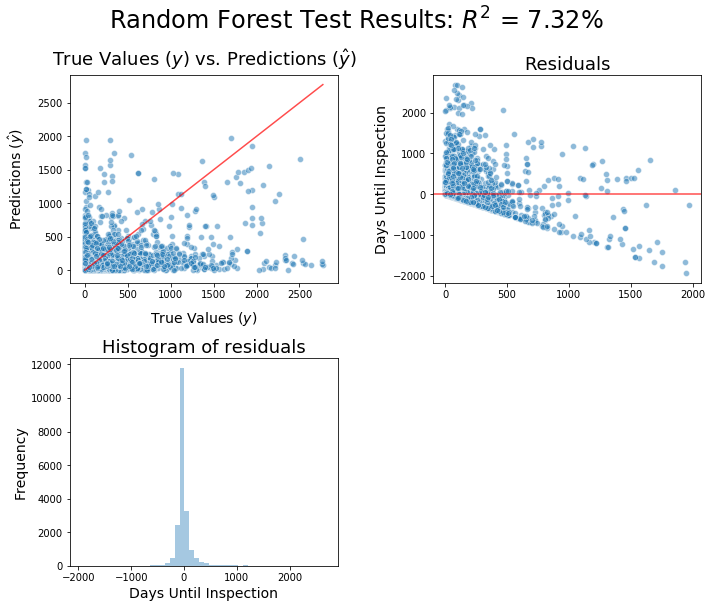

In [96]:
vizResids("Random Forest Test Results","Days Until Inspection", reg_y_test, rf_gs.predict(reg_X_test))

__We see similar situation with the testing data.__ The residuals are normally distributed (bottom left), the model predictions are wildly over and underpredicting (upper left), and the residual plot (upper right) shows a similar heteroscedastic shape.

## Conclusion

We attempted a number of models, including a Generalized Linear Model (GLM), ARIMA models, and SARIMAX models. Despite our best efforts, there seems to be a significant disconnect between our features and our target, the number of days until a complaint was inspected.

Our best performing model was the __Random Forest__ with a training $R^2$ of 35.65% and a testing $R^2$ of a mere 7.32%. Though this model performed better than the other attempted models, it is still severely underfit and has a high variance. Therefore, __we would not advocate using this model as a practical solution to our problem.__

While there could certainly be improvements in our workflow, we feel the most likely answer to our original problem is __predicting the number of days until a complaint will be inspected is not closely linked to the features from the Department of Buildings Complaint dataset or the median income of an area__. 

## Recommendations

It should be noted during this project we performed our analysis and modeling on a fraction of the entire dataset. This was due to practical computational limitations. We did our best to get a randomized sample from all observations within the dataset, though it is possible our subset of data was biased and lead to poor results. Therefore, one of the most important next steps to take should be an __adaptation to cloud-based computing__ that can better handle the size of this dataset. 

We also assumed inclusion of median income data would be beneficial, however, __further outside research around demographics__ may be useful and can be incorporated into further iterations of this project. We should also be mindful of the ethical implications of using such features in our model.

Regarding the clustering we conducted, __further steps can be taken to attempt to optimize the clustering analysis.__ Given our process was limited in computing power, the move to cloud computing would also be beneficial in this regard; the K-prototypes algorithm would be ideal to use as a way of incorporating continuous data, such as income, and categorical data, which is the form most of our data is already in.

We might also be able to __improve time-series model performance by omitting or at least reducing the clearly significant impact on the tail end of our dataset.__

Lastly, we recognize there are a number of __improvements to be made to our time-series models,__ such as included features likely to have an impact on our target, such as weather, the total number of unresolved complaints as any given time interval, or economic data.

## Resources
- [Data Source](https://data.cityofnewyork.us/Housing-Development/DOB-Complaints-Received/eabe-havv)
- [Complaint Codes](https://www1.nyc.gov/assets/buildings/pdf/complaint_category.pdf)
- [Disposition Codes](https://www1.nyc.gov/assets/buildings/pdf/bis_complaint_disposition_codes.pdf)
- [Data Explains](https://docs.google.com/spreadsheets/d/10p0HLqinKbUrSjKaZC2E0ZTHDXgULT0K/edit#gid=1015257717)